In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.spatial import cKDTree
from scipy.sparse import lil_matrix
import copy
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.sparse import spdiags
import scipy.sparse.linalg as linalg
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigs
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from matplotlib import cm
import math

In [4]:
#real parameters
G_fixed = {
    "thresh": 0.00002,
    "max": 10000,
    "dt": #sampling frequency
    #0.001,
    #0.0005, 
    0.005,##original 
    "dx": 3,
    "d": 3,
    "sigma": 10,
    "b": 1.5,
    "r": 40,
    "L": 30,
    "alpha": 1e-4,
    "diff": 0,
    "length": 
    int(1e05 + 1) ##ORIGINAL
    #10000
    #int(1e06 + 1)
}
G = copy.deepcopy(G_fixed)
#new params
def change_param(new, param = "sigma"):
    G[param] = new
    return G

# Define the right-hand side (RHS) function. In this case, Lorenz-63 system
def RHS(y, G):
    f1 = G["sigma"] * (y[1] - y[0])
    f2 = y[0] * (G["r"] - y[2]) - y[1]
    f3 = y[0] * y[1] - G["b"] * y[2]
    f = np.array((f1, f2, f3)).reshape(3, 1)
    return f

# Set initial values and parameters
start = np.array((-11.5, -10, 9.5)).reshape(3, 1)
#G["Y"] = np.identity(G["d"], int) # Unsure about what this line actually does here
nt = 20#transition step size
subset_size = 500 #cell number

# METHOD 1: Euler's Method. Faster and easier to understand, but much greater error
def Euler(G):
    y = start
    ys = copy.deepcopy(y)
    for timestep in range(1, G["length"]): 
        
        y = y + G["dt"] * RHS(y, G)
        ys = np.append(ys, y, axis=1) 
    
    return ys

In [5]:
#REAL trajectory
ys_fixed = Euler(G_fixed)

#CELL CENTER
Xtrain_fixed = ys_fixed.transpose()
sample = MiniBatchKMeans(n_clusters=subset_size).fit(Xtrain_fixed).cluster_centers_
ysample = sample.transpose()


In [6]:
#contruct Markov matrix
def Markov(ys):

    Xtrain = ys.transpose()#POINTS

    #neighbor searching
    bins = [[] for _ in range(subset_size)]
    tree = cKDTree(sample)
    point_dst, point_idxs = tree.query(Xtrain) 
    # Find the nearest cluster center for each solution point and assign them to corresponding bins
    
    for i in range(len(point_idxs)):
        bins[point_idxs[i]].append(i)    
    #point_idxs assign each point to the corresponding cell
    
    #build the transition matrix and find cell edges
    lp = len(point_idxs)

    transitions = point_idxs[nt:lp] - point_idxs[0:(lp - nt)]
    cellEdge = np.flatnonzero(transitions) + 1
    
    M_mat = lil_matrix((subset_size, subset_size))
    for ind in range(0, len(cellEdge) - nt):
        ce = cellEdge[ind] 
        M_mat[point_idxs[ce],point_idxs[ce+nt]] += 1.0
        
# Convert the sparse matrix to a dense matrix
    M_mat = M_mat.toarray()

# Divide each column by the sum of that column
    row_sums = np.sum(M_mat, axis=1)

    for i in range(subset_size):
        if row_sums[i] != 0:
            M_mat[:,i] = M_mat[:,i]/row_sums[i]
        
    return M_mat

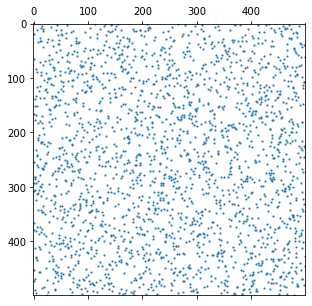

In [7]:

#REAL Markov matrix
M_mat0 = Markov(ys_fixed)


#sanity check of Markov matrix

fig = plt.figure(figsize=(5, 5))
plt.spy(M_mat0, precision=0, marker=None, markersize=1, aspect='equal', origin='upper')

In [8]:
#define a function with input = parameter, output = Markov matrix
def matrix(param):
    return Markov(Euler(change_param(param)))
def obj_fun(x):
    output = []
    for i in x:
        output.append(matrix(i))
    return output

In [ ]:
sigma_025 = [7]
for i in range(24):
    sigma_025.append(sigma_025[i]+.25)

mat_025 = obj_fun(sigma_025)

In [12]:
#(c) matrix - Frobenius norm
def J_c(matrix):

    difference_mat = M_mat0 - matrix
    return math.sqrt(sum(sum(difference_mat**2)))


def mat_comparison(matrices):
    obj_c = []
    for m in matrices:
        obj_c.append(J_c(m))
        
    
    return obj_c

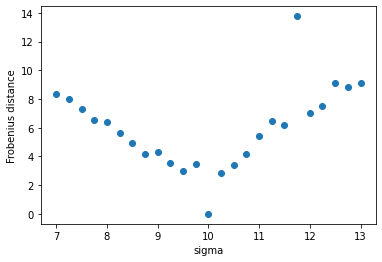

In [16]:
#plot matrices comparison
plt.scatter(sigma_025,mat_comparison(mat_025))
plt.xlabel("sigma")
plt.ylabel('Frobenius distance')
plt.show()